# Single Log File Viewer

Simple notebook for viewing and analyzing individual log files.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Import utilities
sys.path.append(str(Path.cwd()))
from Logger.analysis_helpers_move.utilities import (
    extract_metadata_from_data, 
    calculate_overall_rmse,
    calculate_position_rmse,
    calculate_mean_comp_time,
    detect_trajectory_plane,
    align_reference_to_actual
)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

## Available Log Files

In [75]:
# Get available log files
log_dir = Path('log_files')
log_files = sorted([f.name for f in log_dir.glob('*.csv')])

print("Available log files:")
for i, f in enumerate(log_files, 1):
    print(f"  {i}. {f}")

Available log files:
  1. sim_nr_circle_horz_ds.csv
  2. sim_nr_circle_vert_ds.csv
  3. sim_nr_enhanced_circle_horz_ds.csv
  4. sim_nr_hover_m1_ds.csv
  5. sim_nr_yaw_only_ds.csv


## Select and Load Log File

**Change the filename below to the log file you want to analyze:**

In [88]:
# ===== SELECT LOG FILE HERE =====
selected_file = 'sim_nr_circle_horz_ds.csv'  # <-- Change this
# ================================

df = pd.read_csv(log_dir / selected_file)

# Convert from NED to ENU convention (flip z-axis)
df['z'] = -df['z']
df['z_ref'] = -df['z_ref']
df['vz'] = -df['vz']
df['vz_ref'] = -df['vz_ref']

# Apply lookahead alignment to reference values
# This shifts reference values backward in time to account for lookahead_time
# ensuring we compare the actual state at time t with the reference that was
# planned for time t (not time t + lookahead_time)
df = align_reference_to_actual(df, sampling_rate=10.0)

print(f"\n{'='*60}")
print(f"Loaded: {selected_file}")
print(f"{'='*60}")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Duration: {df['time'].iloc[0]:.3f}s to {df['time'].iloc[-1]:.3f}s ({df['time'].iloc[-1] - df['time'].iloc[0]:.3f}s total)")

Aligning data: shifting reference values back by 1.20s (12 samples)

Loaded: sim_nr_circle_horz_ds.csv
Shape: 287 rows × 34 columns
Duration: 0.171s to 28.770s (28.599s total)


## Data Preview

In [89]:
df.head()

,time,x,y,z,yaw,platform,controller,traj_time,lookahead_time,trajectory,...,q,r,throttle_input,p_input,q_input,r_input,cbf_v_p,cbf_v_q,cbf_v_r,cbf_v_throttle
0,0.171228,-0.028705,-0.003883,0.812376,0.001464,sim,nr,0.155988,1.2,circle_horz,...,-0.002748,-0.000653,0.828680,-0.256185,-0.298620,0.518622,0.0,0.0,0.0,-2.119055
1,0.272536,-0.032748,-0.007899,0.831525,0.002210,NaN,NaN,0.257764,1.2,NaN,...,-0.022677,0.025536,0.862555,0.120429,-0.010502,0.099991,0.0,0.0,0.0,-4.410295
2,0.361036,-0.036713,-0.017611,0.846270,0.005290,NaN,NaN,0.350210,1.2,NaN,...,0.025690,0.030906,0.876461,0.153866,0.045697,-0.003794,0.0,0.0,0.0,-4.070891
3,0.471528,-0.038417,-0.028326,0.867979,0.007362,NaN,NaN,0.457359,1.2,NaN,...,0.039037,0.021010,0.878311,0.144795,0.054816,-0.010698,0.0,0.0,0.0,-3.714949
4,0.576549,-0.040050,-0.040308,0.898760,0.008694,NaN,NaN,0.562368,1.2,NaN,...,0.032697,0.010145,0.878559,0.131232,0.060048,-0.012658,0.0,0.0,0.0,-3.425644


## Metadata and Statistics

In [90]:
# Extract metadata
metadata = extract_metadata_from_data(df)

# Calculate statistics (flip_z=False because we already flipped in the dataframe)
# align_lookahead=False because we already aligned the reference values in cell 5
overall_rmse = calculate_overall_rmse(df, flip_z=False, align_lookahead=False)
position_rmse = calculate_position_rmse(df, flip_z=False, align_lookahead=False)
mean_comp_time = calculate_mean_comp_time(df)

# Build modifiers string
modifiers = []
if metadata['traj_double']:
    modifiers.append('2x Speed')
if metadata['traj_spin']:
    modifiers.append('Spinning')
modifier_str = ', '.join(modifiers) if modifiers else 'None'

# Create metadata table
metadata_table = pd.DataFrame([
    ['Platform', metadata['platform']],
    ['Controller', metadata['controller']],
    ['Trajectory', metadata['trajectory']],
    ['Modifiers', modifier_str],
    ['Duration (s)', f"{df['time'].iloc[-1] - df['time'].iloc[0]:.3f}"],
    ['Samples', len(df)],
    ['Overall RMSE (m)', f"{overall_rmse:.6f}"],
    ['Position RMSE (m)', f"{position_rmse:.6f}"],
    ['Mean Comp Time (ms)', f"{mean_comp_time:.3f}" if mean_comp_time else 'N/A'],
    ['Max Comp Time (ms)', f"{df['comp_time'].max()*1000:.3f}" if 'comp_time' in df.columns else 'N/A']
], columns=['Property', 'Value'])

# Display with nice formatting
from IPython.display import display, HTML
display(HTML(metadata_table.to_html(index=False, justify='left', border=2)))

print(f"\n{'='*60}")
print(f"Key Metrics:")
print(f"{'='*60}")
print(f"  Overall RMSE:     {overall_rmse:.6f} m")
print(f"  Position RMSE:    {position_rmse:.6f} m")
print(f"  Mean Comp Time:   {mean_comp_time:.3f} ms" if mean_comp_time else "  Mean Comp Time:   N/A")

Property,Value
Platform,sim
Controller,nr
Trajectory,circle_horz
Modifiers,"2x Speed, Spinning"
Duration (s),28.599
Samples,287
Overall RMSE (m),1.182664
Position RMSE (m),1.182662
Mean Comp Time (ms),0.698
Max Comp Time (ms),1.509



Key Metrics:
  Overall RMSE:     1.182664 m
  Position RMSE:    1.182662 m
  Mean Comp Time:   0.698 ms


## Position & Yaw: Actual vs Reference

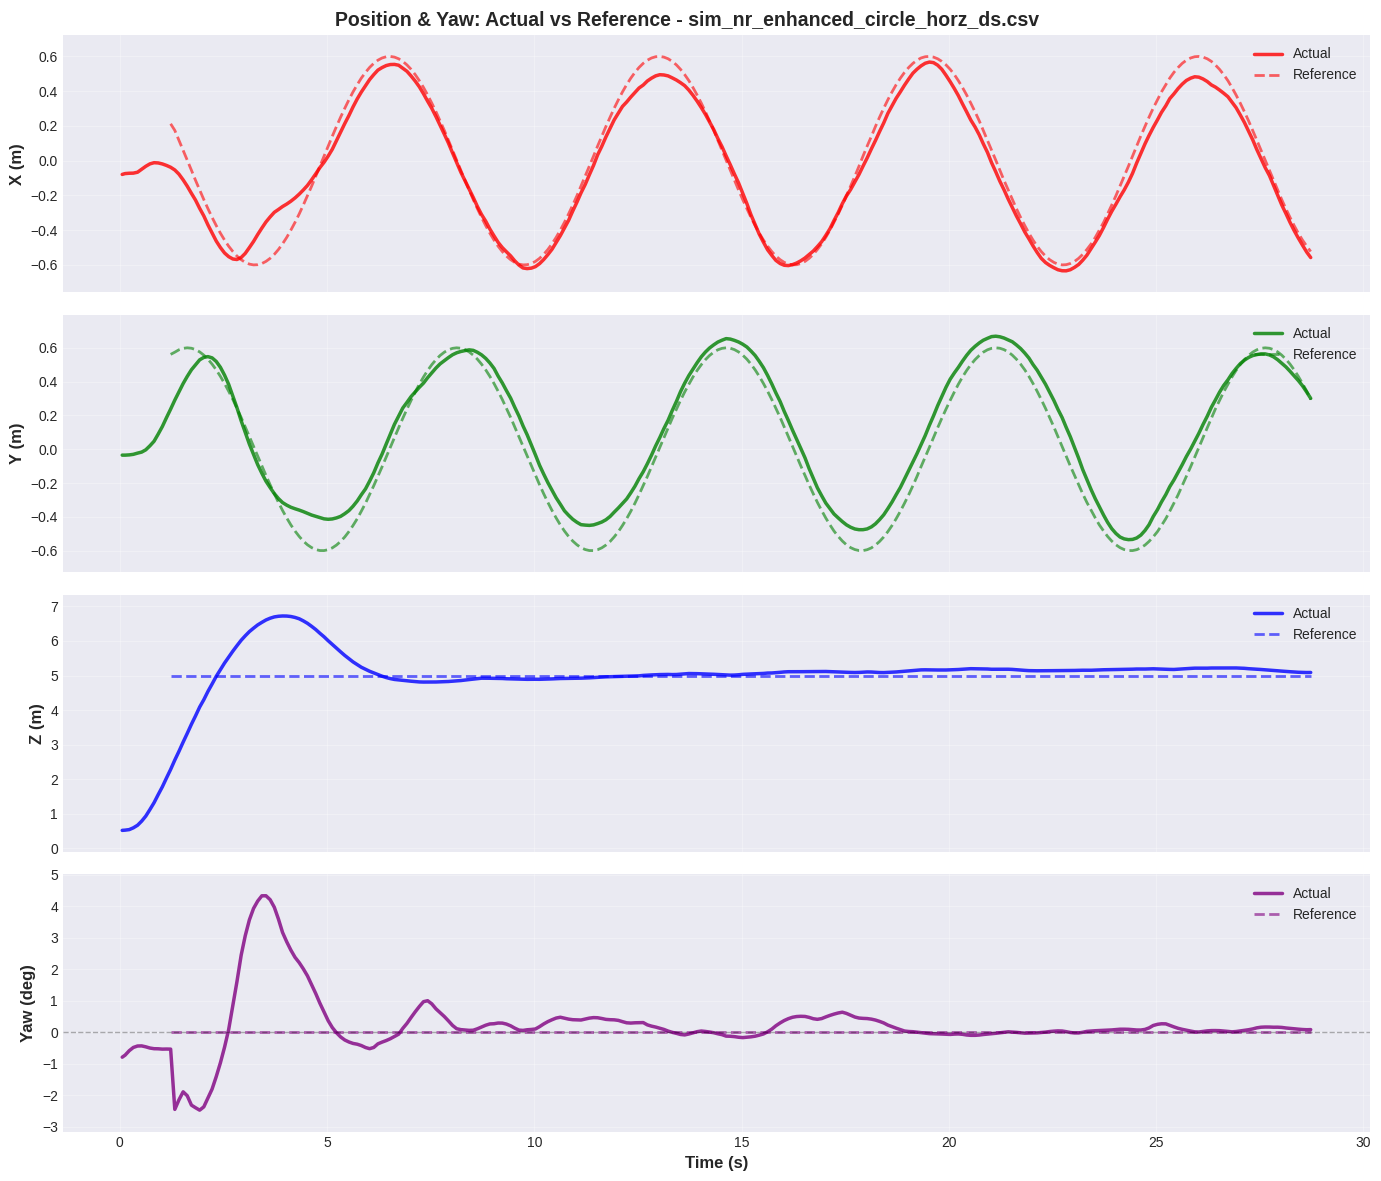

In [79]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Position coordinates
coords = [('x', 'x_ref', 'X', 'red', 'm'), 
          ('y', 'y_ref', 'Y', 'green', 'm'), 
          ('z', 'z_ref', 'Z', 'blue', 'm')]

for ax, (actual, ref, label, color, unit) in zip(axes[:3], coords):
    ax.plot(df['time'], df[actual], color=color, label='Actual', linewidth=2.5, alpha=0.8)
    ax.plot(df['time'], df[ref], color=color, linestyle='--', label='Reference', linewidth=2, alpha=0.6)
    
    # Add equal margins on both ends
    data_max = max(df[actual].max(), df[ref].max())
    data_min = min(df[actual].min(), df[ref].min())
    data_range = data_max - data_min
    margin = data_range * 0.1 if data_range > 0 else 0.1
    ax.set_ylim(data_min - margin, data_max + margin)
    
    ax.set_ylabel(f'{label} ({unit})', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)
    ax.tick_params(labelsize=10)

# Yaw (4th subplot)
yaw_deg = np.rad2deg(df['yaw'])
yaw_ref_deg = np.rad2deg(df['yaw_ref'])

axes[3].plot(df['time'], yaw_deg, color='purple', label='Actual', linewidth=2.5, alpha=0.8)
axes[3].plot(df['time'], yaw_ref_deg, color='purple', linestyle='--', label='Reference', linewidth=2, alpha=0.6)

# Add equal margins on both ends
data_max = max(yaw_deg.max(), yaw_ref_deg.max())
data_min = min(yaw_deg.min(), yaw_ref_deg.min())
data_range = data_max - data_min
margin = data_range * 0.1 if data_range > 0 else 1.0
axes[3].set_ylim(data_min - margin, data_max + margin)

axes[3].set_ylabel('Yaw (deg)', fontsize=12, fontweight='bold')
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper right', fontsize=10)
axes[3].axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.3)
axes[3].tick_params(labelsize=10)

axes[-1].set_xlabel('Time (s)', fontsize=12, fontweight='bold')
fig.suptitle(f'Position & Yaw: Actual vs Reference - {selected_file}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2D Trajectory (Auto-detected Plane)

Detected trajectory plane: XY


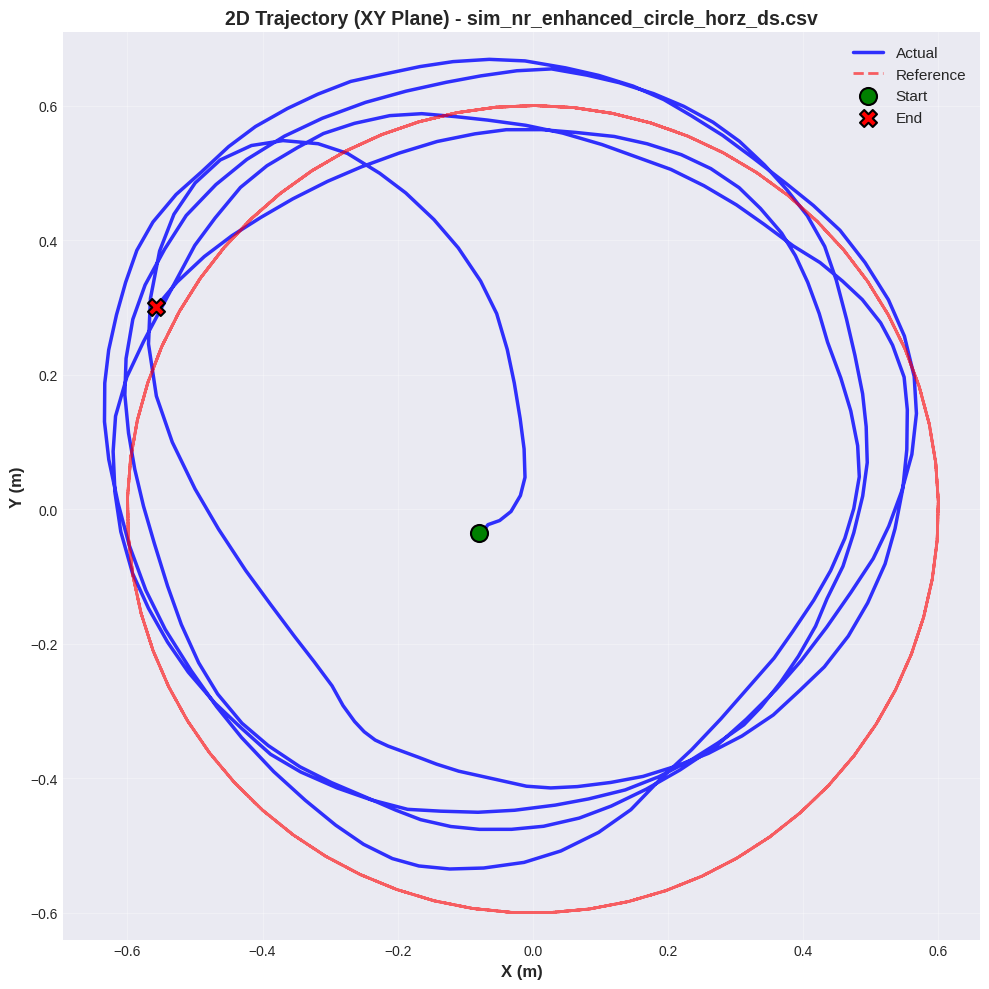

In [80]:
# Detect the primary plane of motion
plane = detect_trajectory_plane(df)

# Map plane to axis names
axis_map = {
    'xy': ('x', 'y', 'X', 'Y'),
    'xz': ('x', 'z', 'X', 'Z'),
    'yz': ('y', 'z', 'Y', 'Z')
}

x_col, y_col, x_label, y_label = axis_map[plane]
x_ref_col, y_ref_col = f'{x_col}_ref', f'{y_col}_ref'

print(f"Detected trajectory plane: {plane.upper()}")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot trajectories
ax.plot(df[x_col], df[y_col], 'b-', label='Actual', linewidth=2.5, alpha=0.8)
ax.plot(df[x_ref_col], df[y_ref_col], 'r--', label='Reference', linewidth=2, alpha=0.6)

# Mark start and end
ax.scatter(df[x_col].iloc[0], df[y_col].iloc[0], 
           c='green', s=150, marker='o', label='Start', zorder=5, edgecolors='black', linewidths=1.5)
ax.scatter(df[x_col].iloc[-1], df[y_col].iloc[-1], 
           c='red', s=150, marker='X', label='End', zorder=5, edgecolors='black', linewidths=1.5)

ax.set_xlabel(f'{x_label} (m)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'{y_label} (m)', fontsize=12, fontweight='bold')
ax.set_title(f'2D Trajectory ({plane.upper()} Plane) - {selected_file}', fontsize=14, fontweight='bold')
ax.set_aspect('equal', adjustable='datalim')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Position Errors

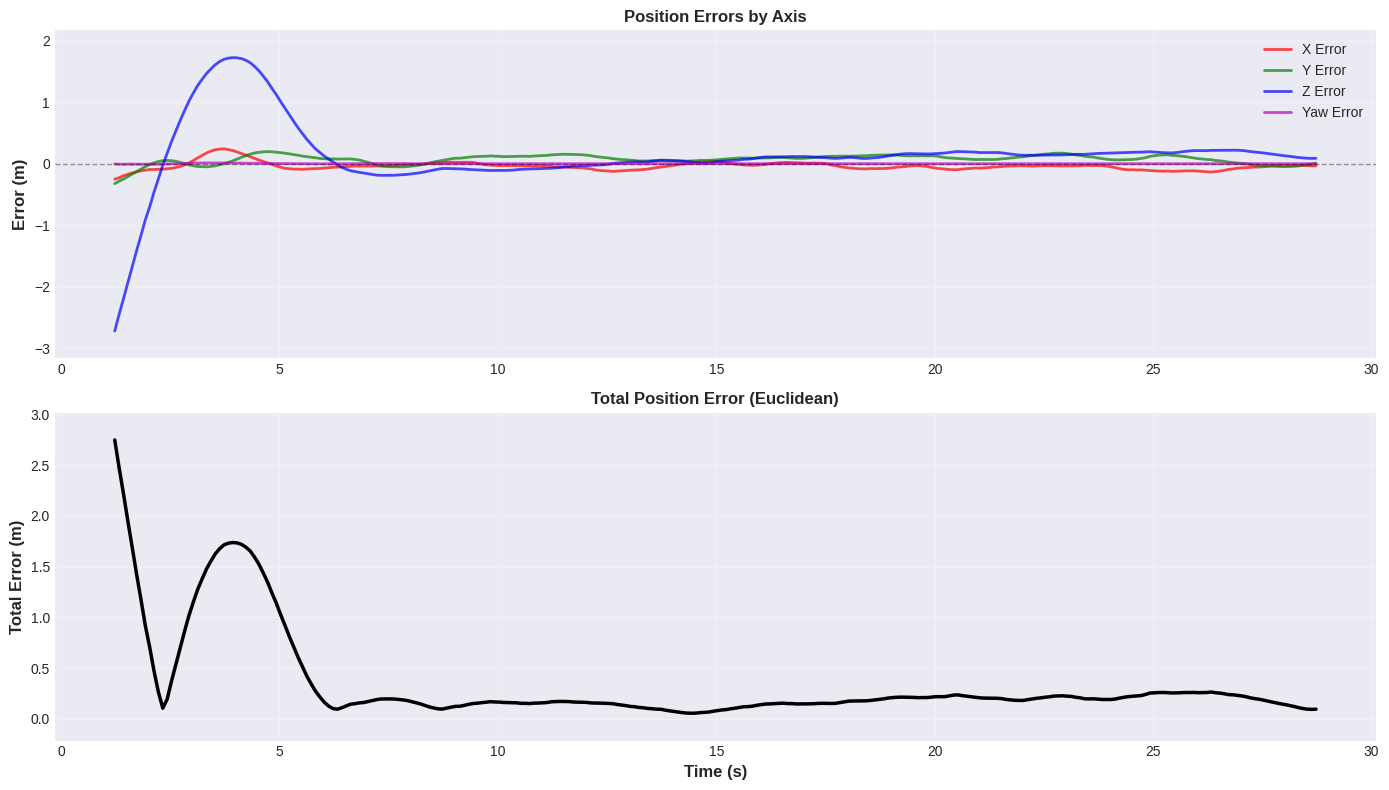


Position Error Statistics:
  Mean Total Error: 0.343550 m
  Max Total Error:  2.749608 m
  Min Total Error:  0.055171 m
  RMSE:             0.575271 m
  Std Dev:          0.462260 m


In [81]:
# Calculate errors
error_x = df['x'] - df['x_ref']
error_y = df['y'] - df['y_ref']
error_z = df['z'] - df['z_ref']
error_yaw = 0.18 * (df['yaw'] - df['yaw_ref'])
error_norm = np.sqrt(error_x**2 + error_y**2 + error_z**2 + error_yaw**2)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Individual errors
axes[0].plot(df['time'], error_x, 'r-', label='X Error', linewidth=2, alpha=0.7)
axes[0].plot(df['time'], error_y, 'g-', label='Y Error', linewidth=2, alpha=0.7)
axes[0].plot(df['time'], error_z, 'b-', label='Z Error', linewidth=2, alpha=0.7)
axes[0].plot(df['time'], error_yaw, 'm-', label='Yaw Error', linewidth=2, alpha=0.7)
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.4)

# Add equal margins on both ends
err_max = max(error_x.max(), error_y.max(), error_z.max())
err_min = min(error_x.min(), error_y.min(), error_z.min())
err_range = err_max - err_min
margin = err_range * 0.1 if err_range > 0 else 0.01
axes[0].set_ylim(err_min - margin, err_max + margin)

axes[0].set_ylabel('Error (m)', fontsize=12, fontweight='bold')
axes[0].set_title('Position Errors by Axis', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Total error
axes[1].plot(df['time'], error_norm, 'k-', linewidth=2.5)

# Add equal margins on both ends
norm_max = error_norm.max()
norm_min = error_norm.min()
norm_range = norm_max - norm_min
margin = norm_range * 0.1 if norm_range > 0 else 0.01
axes[1].set_ylim(norm_min - margin, norm_max + margin)

axes[1].set_xlabel('Time (s)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Error (m)', fontsize=12, fontweight='bold')
axes[1].set_title('Total Position Error (Euclidean)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*60}")
print("Position Error Statistics:")
print(f"{'='*60}")
print(f"  Mean Total Error: {error_norm.mean():.6f} m")
print(f"  Max Total Error:  {error_norm.max():.6f} m")
print(f"  Min Total Error:  {error_norm.min():.6f} m")
print(f"  RMSE:             {np.sqrt((error_norm**2).mean()):.6f} m")
print(f"  Std Dev:          {error_norm.std():.6f} m")

## Velocity: Actual vs Reference

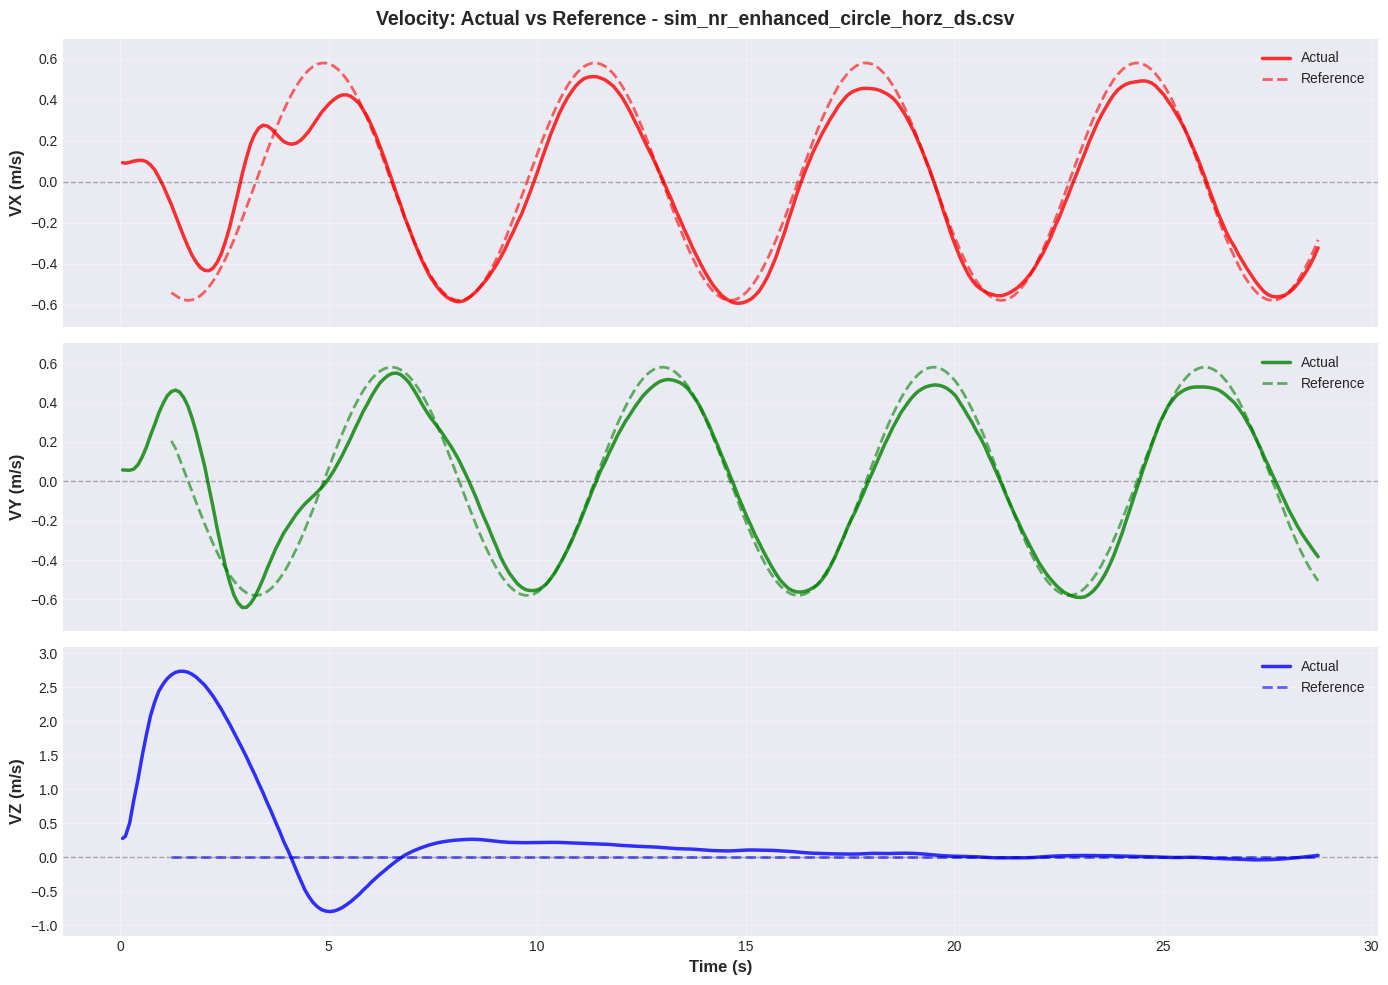

In [82]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

vels = [('vx', 'vx_ref', 'VX', 'red'), 
        ('vy', 'vy_ref', 'VY', 'green'), 
        ('vz', 'vz_ref', 'VZ', 'blue')]

for ax, (actual, ref, label, color) in zip(axes, vels):
    ax.plot(df['time'], df[actual], color=color, label='Actual', linewidth=2.5, alpha=0.8)
    ax.plot(df['time'], df[ref], color=color, linestyle='--', label='Reference', linewidth=2, alpha=0.6)
    
    # Add equal margins on both ends
    data_max = max(df[actual].max(), df[ref].max())
    data_min = min(df[actual].min(), df[ref].min())
    data_range = data_max - data_min
    margin = data_range * 0.1 if data_range > 0 else 0.1
    ax.set_ylim(data_min - margin, data_max + margin)
    
    ax.set_ylabel(f'{label} (m/s)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.3)
    ax.tick_params(labelsize=10)

axes[-1].set_xlabel('Time (s)', fontsize=12, fontweight='bold')
fig.suptitle(f'Velocity: Actual vs Reference - {selected_file}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Body Rates (p, q, r)

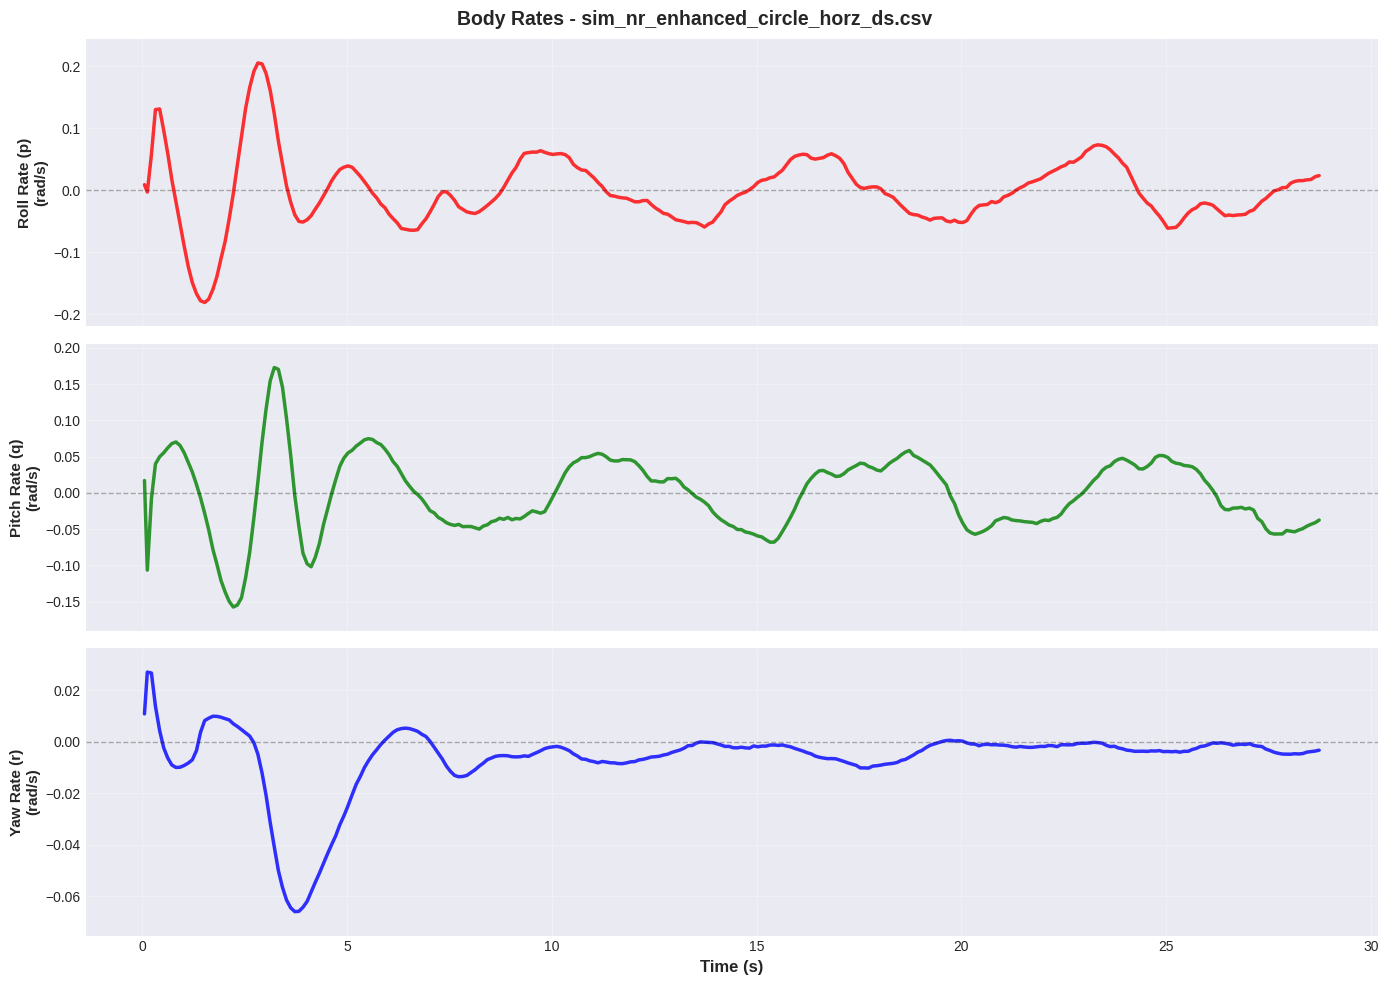

In [83]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

rates = [('p', 'Roll Rate (p)', 'red'), 
         ('q', 'Pitch Rate (q)', 'green'), 
         ('r', 'Yaw Rate (r)', 'blue')]

for ax, (rate, label, color) in zip(axes, rates):
    ax.plot(df['time'], df[rate], color=color, linewidth=2.5, alpha=0.8)
    
    # Add equal margins on both ends
    data_max = df[rate].max()
    data_min = df[rate].min()
    data_range = data_max - data_min
    margin = data_range * 0.1 if data_range > 0 else 0.1
    ax.set_ylim(data_min - margin, data_max + margin)
    
    ax.set_ylabel(f'{label}\n(rad/s)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.3)
    ax.tick_params(labelsize=10)

axes[-1].set_xlabel('Time (s)', fontsize=12, fontweight='bold')
fig.suptitle(f'Body Rates - {selected_file}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Control Inputs

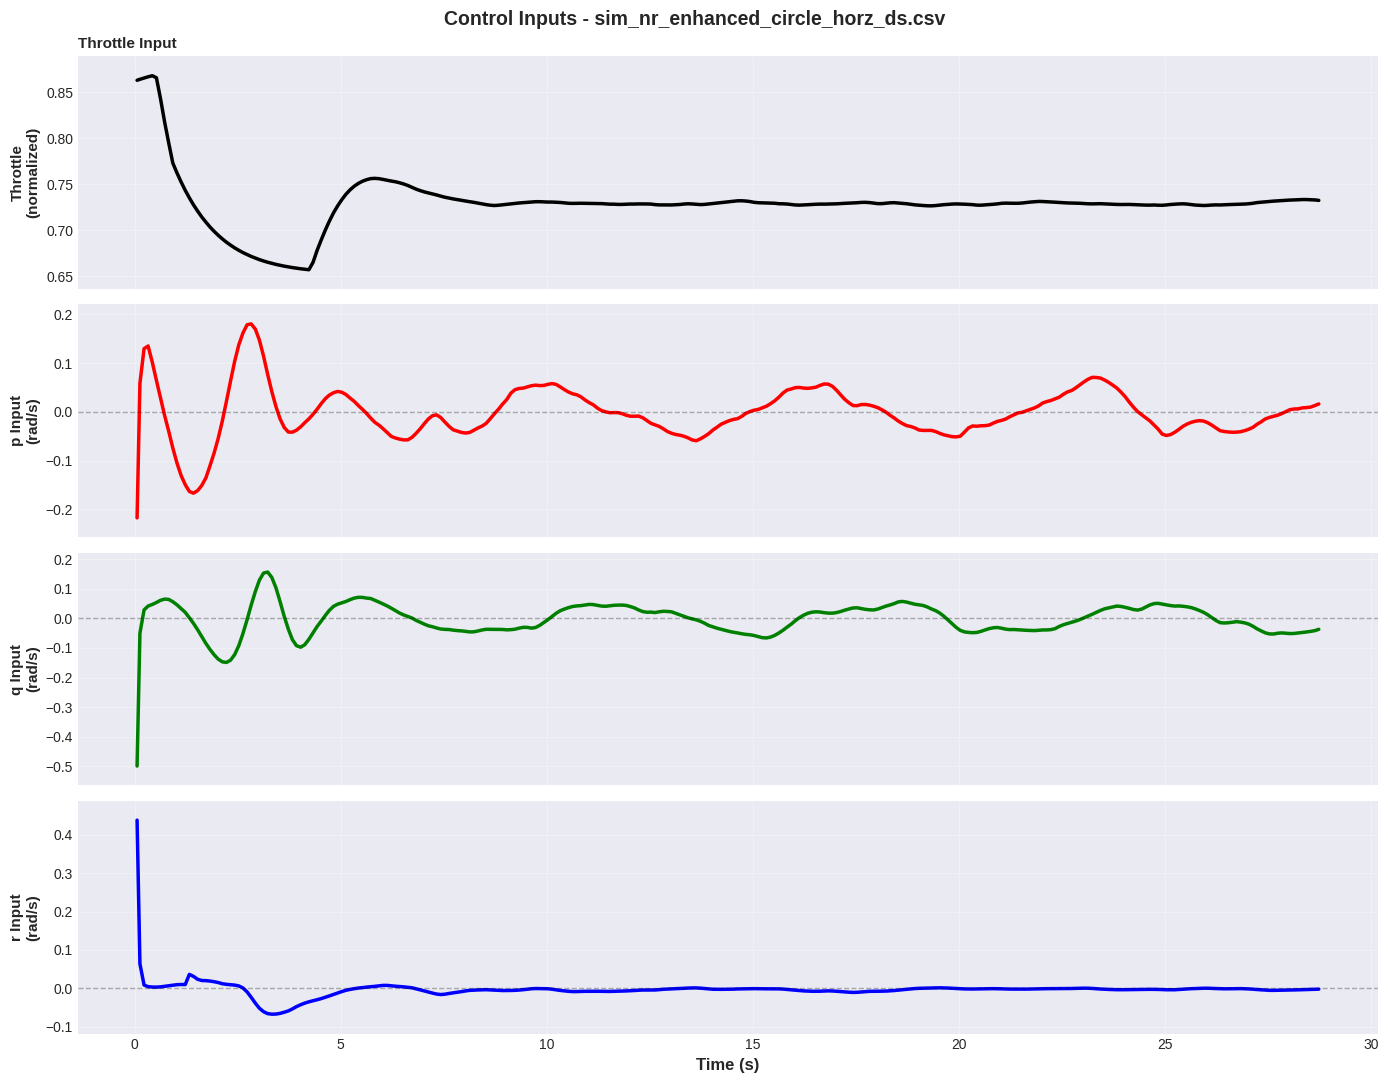

In [84]:
fig, axes = plt.subplots(4, 1, figsize=(14, 11), sharex=True)

# Throttle
axes[0].plot(df['time'], df['throttle_input'], 'k-', linewidth=2.5)
data_max = df['throttle_input'].max()
data_min = df['throttle_input'].min()
data_range = data_max - data_min
margin = data_range * 0.1 if data_range > 0 else 0.05
axes[0].set_ylim(data_min - margin, data_max + margin)
axes[0].set_ylabel('Throttle\n(normalized)', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Throttle Input', fontsize=11, loc='left', fontweight='bold')

# Body rate inputs
inputs = [('p_input', 'p Input', 'red'), 
          ('q_input', 'q Input', 'green'), 
          ('r_input', 'r Input', 'blue')]

for i, (ax, (inp, label, color)) in enumerate(zip(axes[1:], inputs), 1):
    ax.plot(df['time'], df[inp], color=color, linewidth=2.5)
    
    # Add equal margins on both ends
    data_max = df[inp].max()
    data_min = df[inp].min()
    data_range = data_max - data_min
    margin = data_range * 0.1 if data_range > 0 else 0.1
    ax.set_ylim(data_min - margin, data_max + margin)
    
    ax.set_ylabel(f'{label}\n(rad/s)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.3)

axes[-1].set_xlabel('Time (s)', fontsize=12, fontweight='bold')
fig.suptitle(f'Control Inputs - {selected_file}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## CBF Values

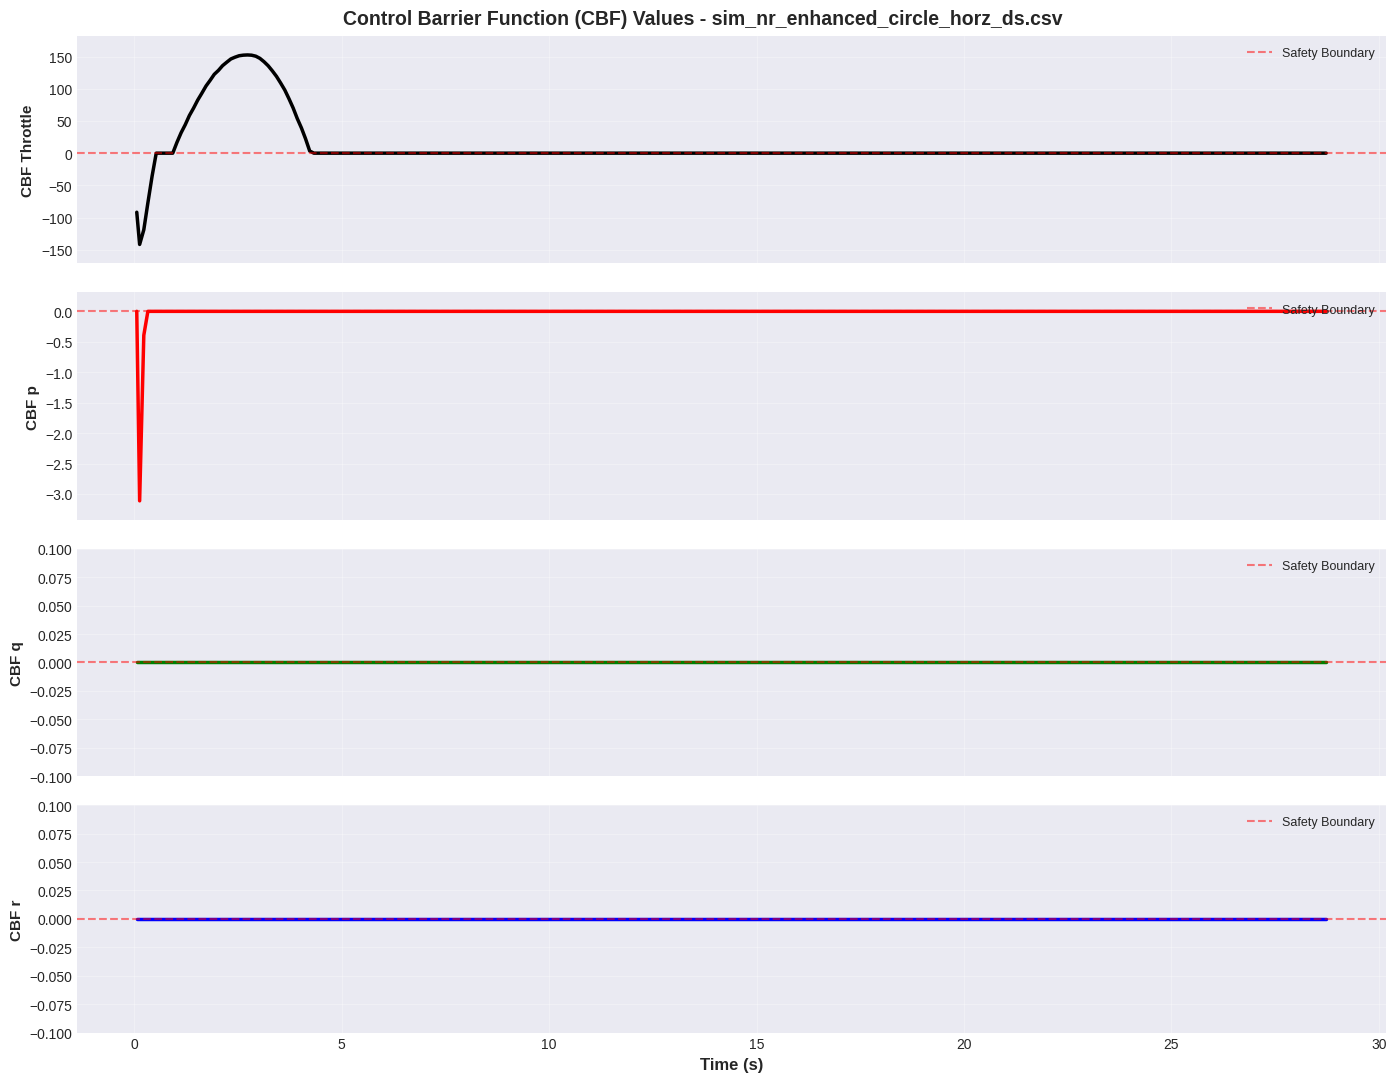


CBF Statistics (negative values indicate constraint violations):

CBF Throttle:
  Min value:        -141.830282
  Mean value:       10.016008
  Violations:       5 / 288 (1.74%)

CBF p:
  Min value:        -3.112485
  Mean value:       -0.012172
  Violations:       2 / 288 (0.69%)

CBF q:
  Min value:        0.000000
  Mean value:       0.000000
  Violations:       0 / 288 (0.00%)

CBF r:
  Min value:        0.000000
  Mean value:       0.000000
  Violations:       0 / 288 (0.00%)


In [85]:
fig, axes = plt.subplots(4, 1, figsize=(14, 11), sharex=True)

cbfs = [('cbf_v_throttle', 'CBF Throttle', 'black'), 
        ('cbf_v_p', 'CBF p', 'red'), 
        ('cbf_v_q', 'CBF q', 'green'), 
        ('cbf_v_r', 'CBF r', 'blue')]

for ax, (cbf, label, color) in zip(axes, cbfs):
    ax.plot(df['time'], df[cbf], color=color, linewidth=2.5)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Safety Boundary')
    
    # Add equal margins on both ends
    data_max = df[cbf].max()
    data_min = df[cbf].min()
    data_range = data_max - data_min
    margin = data_range * 0.1 if data_range > 0 else 0.1
    ax.set_ylim(data_min - margin, data_max + margin)
    
    ax.set_ylabel(label, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    ax.tick_params(labelsize=10)

axes[-1].set_xlabel('Time (s)', fontsize=12, fontweight='bold')
fig.suptitle(f'Control Barrier Function (CBF) Values - {selected_file}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print CBF statistics
print(f"\n{'='*60}")
print("CBF Statistics (negative values indicate constraint violations):")
print(f"{'='*60}")
for cbf, label, _ in cbfs:
    violations = (df[cbf] < 0).sum()
    violation_pct = (violations / len(df)) * 100
    print(f"\n{label}:")
    print(f"  Min value:        {df[cbf].min():.6f}")
    print(f"  Mean value:       {df[cbf].mean():.6f}")
    print(f"  Violations:       {violations} / {len(df)} ({violation_pct:.2f}%)")

## Computation Time

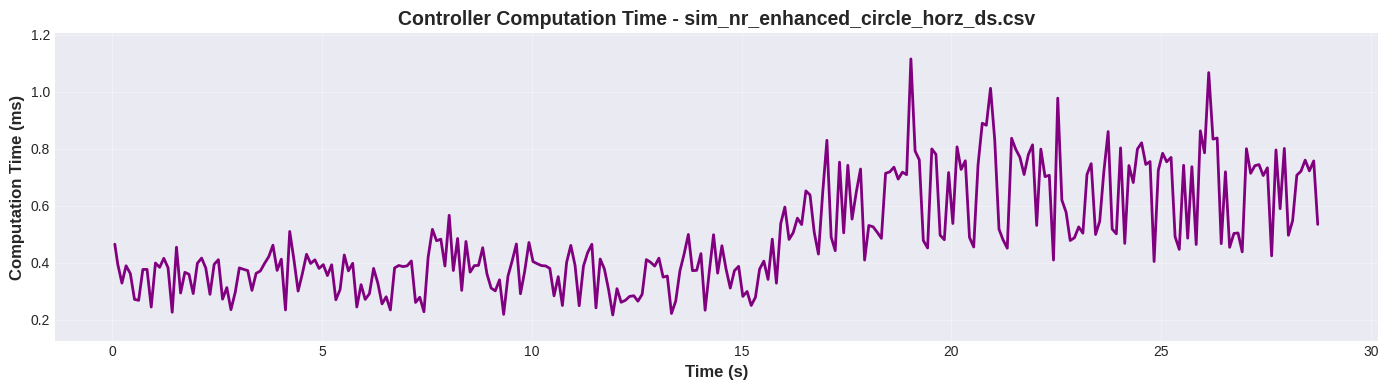


Computation Time Statistics:
  Mean: 0.491 ms
  Max:  1.115 ms
  Min:  0.216 ms
  Std:  0.187 ms


In [86]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

comp_time_ms = df['comp_time'] * 1000
ax.plot(df['time'], comp_time_ms, 'purple', linewidth=2)

# Add equal margins on both ends
data_max = comp_time_ms.max()
data_min = comp_time_ms.min()
data_range = data_max - data_min
margin = data_range * 0.1 if data_range > 0 else 0.1
ax.set_ylim(data_min - margin, data_max + margin)

ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Computation Time (ms)', fontsize=12, fontweight='bold')
ax.set_title(f'Controller Computation Time - {selected_file}', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Computation Time Statistics:")
print(f"{'='*60}")
print(f"  Mean: {comp_time_ms.mean():.3f} ms")
print(f"  Max:  {comp_time_ms.max():.3f} ms")
print(f"  Min:  {comp_time_ms.min():.3f} ms")
print(f"  Std:  {comp_time_ms.std():.3f} ms")

## 3D Trajectory

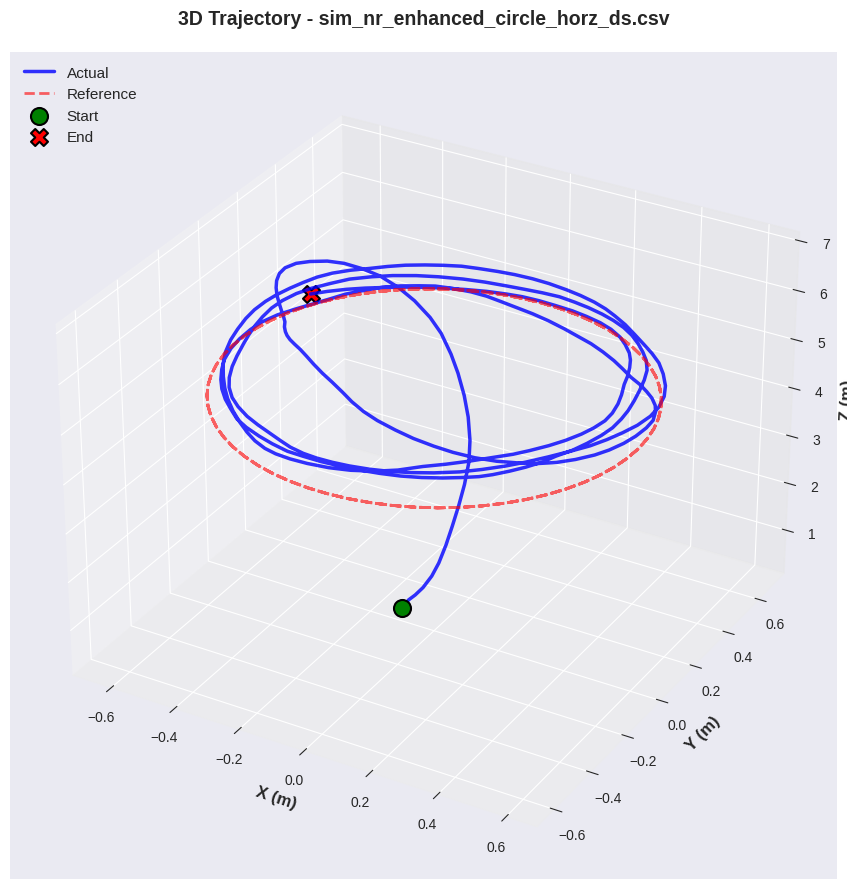

In [87]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectories
ax.plot(df['x'], df['y'], df['z'], 'b-', label='Actual', linewidth=2.5, alpha=0.8)
ax.plot(df['x_ref'], df['y_ref'], df['z_ref'], 'r--', label='Reference', linewidth=2, alpha=0.6)

# Mark start and end
ax.scatter(df['x'].iloc[0], df['y'].iloc[0], df['z'].iloc[0], 
           c='green', s=150, marker='o', label='Start', zorder=5, edgecolors='black', linewidths=1.5)
ax.scatter(df['x'].iloc[-1], df['y'].iloc[-1], df['z'].iloc[-1], 
           c='red', s=150, marker='X', label='End', zorder=5, edgecolors='black', linewidths=1.5)

ax.set_xlabel('X (m)', fontsize=12, fontweight='bold')
ax.set_ylabel('Y (m)', fontsize=12, fontweight='bold')
ax.set_zlabel('Z (m)', fontsize=12, fontweight='bold')
ax.set_title(f'3D Trajectory - {selected_file}', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()